# Выбор локации для скважины

_____
**Описание исследования.**

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


_____
**Цели исследования.**
    
Построить модель машинного обучения, которая определит регион, где добыча принесёт наибольшую прибыль


_____
**Исходные данные.**
    
- **id** — уникальный идентификатор скважины.


- **f0, f1, f2** — три признака точек.


- **product** — объём запасов в скважине (тыс. баррелей).

_____
**Данное исследование разделим на четыре этапа:**



1. [Выполнить загрузку и подготовку данных](#section2), провести [исследовательский](#section3) анализ данных.
<a href='#section2'></a>
<a href='#section3'></a>


2.  [Провести обучение и проверку модели.](#section4)
<a href='#section4'></a>


3. [Подготовиться к расчёту прибыли.](#section5)
<a href='#section5'></a>


4. [Провести расчёт прибыли и рисков.](#section6)
<a href='#section6'></a>



### Библиотеки и окружение

In [ ]:
!pip install matplotlib==3.8.4 -q

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
!pip install scikit-learn==1.4.0 -q

In [ ]:
pip install phik==0.12.4 -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install seaborn==0.13.2 -q

In [ ]:
import seaborn as sns

In [ ]:
import numpy as np
import pandas as pd
import math

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

**Функции:**

In [ ]:
# Вывод уникальных значений, количества пропусков и дубликатов.
def check(row):
    col = row.columns
    dupli = row.duplicated().sum()
    print('Количество явных дубликатов:', dupli)
    nans = row.isna().sum().sum()
    print('Количество пропусков в данных:', nans)
    if dupli > 0:
        print(row.duplicated())
    for col_l in col:
        print('-'* 30)
        print('Уникальные значения:', col_l, row[col_l].sort_values().unique())

In [ ]:
# Вывод гистограмм, pie-диаграмм, сводных таблиц
def sign(row,column, title):
    if row.dtypes[column] == object:
        row[column].value_counts().plot.barh(figsize=(10, 5), grid= True)
        plt.title(title, fontsize=15)
        plt.ylabel('Количество')
        plt.rc('xtick', labelsize= 15 )
        plt.rc('ytick', labelsize= 15 )
        plt.show()
        one = pd.pivot_table(
            row,
            index=column,
            values = 'id',
            aggfunc='count')
        plt.title(title, fontsize=20)
        row[column].value_counts().plot(
            kind = 'pie',
            figsize=(10,10),
            autopct = '%0.01f%%',
            colors=sns.color_palette('Set2')
        )
        ax = plt.gca()
        #ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.show()
        one['% '] = round(one['id']/one['id'].sum()*100,2)
        one.rename(columns={'id':'количество'},
              inplace=True)
        return one

    else:
        fig, axes = plt.subplots(2, figsize=(15, 15), sharey='row')
        #axes[0].plot(row[column], kind='bar')
        axes[0].hist(row[column], bins=int(len(row) ** (0.5)))
        axes[0].grid(True)
        axes[0].set_title(title, fontsize=20)
        axes[0].set_ylabel('Количество')
        axes[1].boxplot(data=row, x=column, vert=False, patch_artist=True)
        axes[1].grid(True)
        axes[1].set_xlabel(title)
        plt.show()
        return row[column].describe().T

<a id='section2'></a>
## Загрузка и подготовка данных

In [ ]:
df_0 =  pd.read_csv('/datasets/geo_data_0.csv')
df_1 =  pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')


In [ ]:
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [ ]:
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [ ]:
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### Подготовка данных

In [ ]:
check(df_0)

Количество явных дубликатов: 0
Количество пропусков в данных: 0
------------------------------
Уникальные значения: id ['006OJ' '009eY' '00AfQ' ... 'zztWK' 'zzyhQ' 'zzzLH']
------------------------------
Уникальные значения: f0 [-1.40860531 -1.35177299 -1.30222711 ...  2.33375269  2.33707957
  2.36233081]
------------------------------
Уникальные значения: f1 [-0.8482185  -0.84490792 -0.8205609  ...  1.33334561  1.33482762
  1.34376933]
------------------------------
Уникальные значения: f2 [-12.08832812 -10.13834135 -10.13817115 ...  15.23032159  15.42837187
  16.00379001]
------------------------------
Уникальные значения: product [0.00000000e+00 4.02152316e-03 6.11363631e-03 ... 1.85355615e+02
 1.85362690e+02 1.85364347e+02]


In [ ]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [ ]:
check(df_1)

Количество явных дубликатов: 0
Количество пропусков в данных: 0
------------------------------
Уникальные значения: id ['0022J' '003Gl' '003Vx' ... 'zzv4E' 'zzy2c' 'zzzvI']
------------------------------
Уникальные значения: f0 [-31.60957602 -27.82961614 -26.64625507 ...  28.93082879  29.25906208
  29.42175461]
------------------------------
Уникальные значения: f1 [-26.35859801 -25.38962242 -25.2915177  ...  16.0268693   16.7371962
  18.73406263]
------------------------------
Уникальные значения: f2 [-0.01814409 -0.01788668 -0.01768626 ...  5.01750345  5.01909142
  5.01972056]
------------------------------
Уникальные значения: product [  0.           3.17910258  26.95326103  30.13236361  53.90652206
  57.08562465  80.85978309  84.03888568 107.81304413 110.99214671
 134.76630516 137.94540774]


In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [ ]:
check(df_2)

Количество явных дубликатов: 0
Количество пропусков в данных: 0
------------------------------
Уникальные значения: id ['009Gl' '00AuD' '00CaL' ... 'zzqqy' 'zzsKd' 'zzz9h']
------------------------------
Уникальные значения: f0 [-8.76000362 -7.45058711 -7.18949804 ...  7.19461485  7.21552717
  7.23826248]
------------------------------
Уникальные значения: f1 [-7.08401976 -6.74835677 -6.73299712 ...  7.10161842  7.76185714
  7.84480127]
------------------------------
Уникальные значения: f2 [-11.97033454 -11.61169048 -11.40724351 ...  16.31301122  16.35764509
  16.73940206]
------------------------------
Уникальные значения: product [0.00000000e+00 4.60600004e-03 9.20411196e-03 ... 1.90011722e+02
 1.90013589e+02 1.90029838e+02]


In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


<a id='section3'></a>
### Исследовательский анализ.

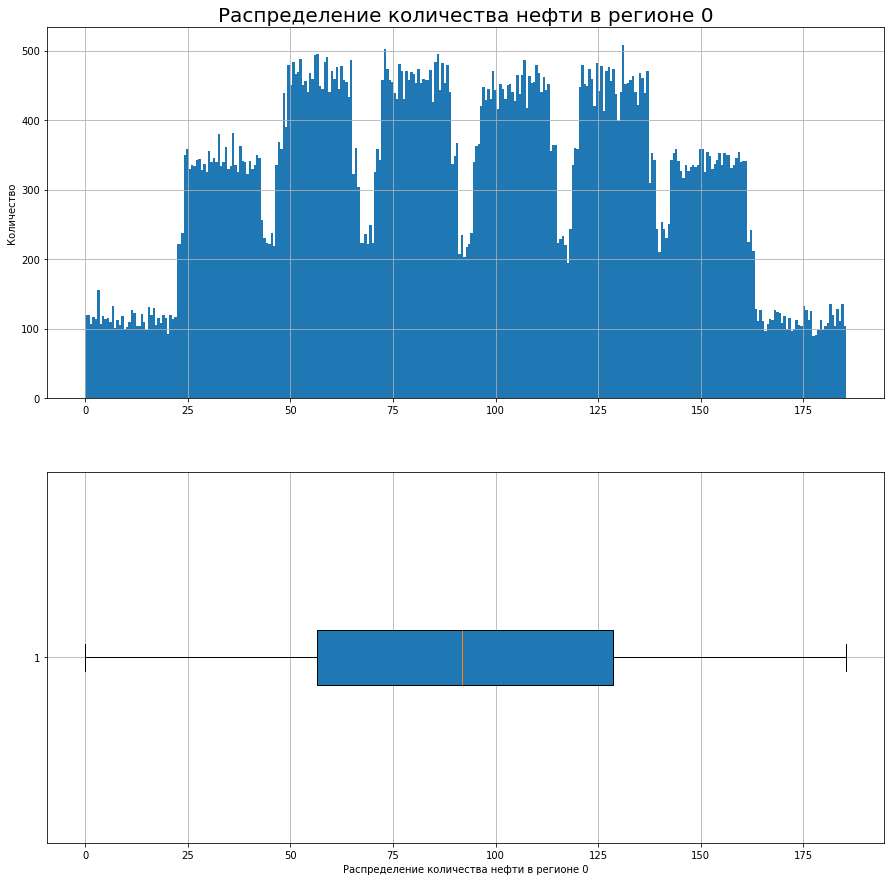

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

In [ ]:
sign(df_0, 'product', 'Распределение количества нефти в регионе 0')

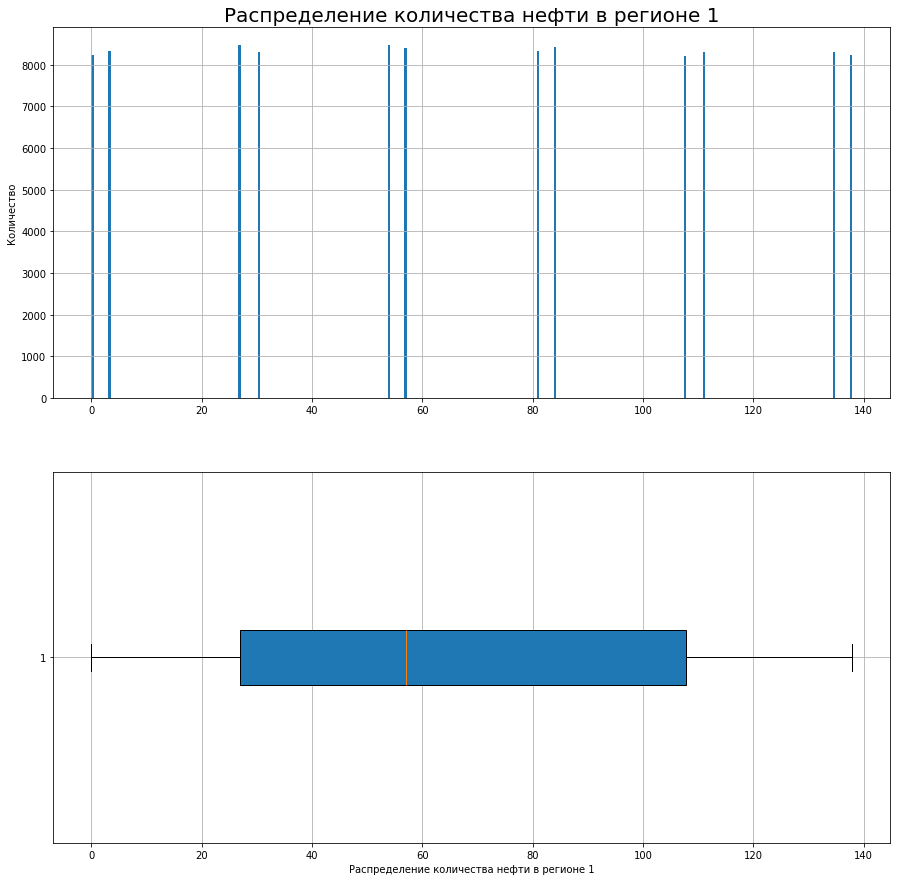

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

In [ ]:
sign(df_1, 'product', 'Распределение количества нефти в регионе 1')

Видим что значения гистограммы близки к разбиению на категории, возможно замеры количества нефти в данном регионе отличаются или передача показаний происходила неккоректно.

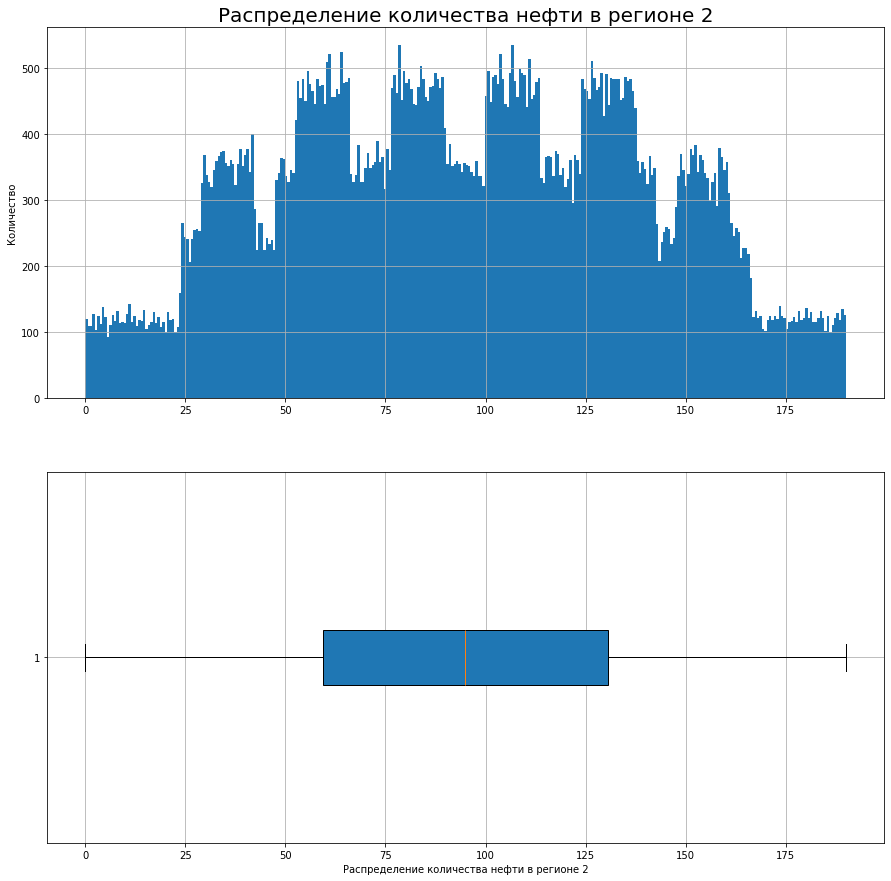

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

In [ ]:
sign(df_2, 'product', 'Распределение количества нефти в регионе 2')

<a id='section4'></a>
## Обучение и проверка модели

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [ ]:
def prepare(row):
    X = row.drop(['id', 'product'], axis = 1)
    target = row['product']

    X_train, X_test, y_train, y_test = train_test_split(
    X,
    target,
    test_size = 0.25,
    random_state = 42
    )
    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    X_test_pred = pd.DataFrame(X_test)
    X_test_pred['предсказание'] = model.predict(X_test)
    one = X_test_pred['предсказание'].mean()

    return X_test_pred, model, pred, y_test, one

In [ ]:
def rmse_mean(row, title):
    print(title)
    X_test_pred, model, pred, y_test, one = prepare(row)
    rmse = sqrt(mean_squared_error(y_test, pred))
    print('RMSE модели:', rmse)

    print('Средний запас предсказанного сырья:', one)

### Регион 0

In [ ]:
rmse_mean(df_0, 'Регион 0')

Регион 0
RMSE модели: 37.75660035026169
Средний запас предсказанного сырья: 92.39879990657768


In [ ]:
region_0, model_0, pred_0, y_test_0, mean_0 = prepare(df_0)

### Регион 1

In [ ]:
rmse_mean(df_1, 'Регион 1')

Регион 1
RMSE модели: 0.890280100102884
Средний запас предсказанного сырья: 68.71287803913762


In [ ]:
region_1, model_1, pred_1, y_test_1, mean_1 = prepare(df_1)

### Регион 2

In [ ]:
rmse_mean(df_2, 'Регион 2')

Регион 2
RMSE модели: 40.145872311342174
Средний запас предсказанного сырья: 94.77102387765939


In [ ]:
region_2, model_2, pred_2, y_test_2, mean_2 = prepare(df_2)

### Вывод

Лучшая метрика у региона 1, при этом средний запас предсказанного сырья ниже остальных регионов почти на треть.

<div class="alert alert-block alert-success">
<b>Успех:</b> Модели обучены корректно. Радует, что ты активно используешь функции. Это помогает избежать дублирования кода, а значит уменьшает вероятность совершить ошибку/опечатку!
</div>

<a id='section5'></a>
## Подготовка к расчёту прибыли

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Доход с каждого барреля продукта составляет 450 тыс. рублей.

In [ ]:
fs_points = 500
fs_best = 200
budget = 10000000000
price_per_bar = 450000
proba_line = 2.5
price_per_budget = budget/ price_per_bar # Посчитаем сколько тыс. баррелей в бюджете

In [ ]:
raw_mean = price_per_budget/fs_best
print('Достаточный объём сырья для безубыточной разработки новой скважины:',
      round(raw_mean,2), 'тыс. баррелей')


Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей


In [ ]:
pred_per_df = {'Регион_0':df_0['product'], 'Регион_1':df_1['product'], 'Регион_2':df_2['product']}
pred_per_df = pd.DataFrame(data  = pred_per_df)

In [ ]:
def raw_great(row):
    for column in pred_per_df.columns:
        print(f'Количество скважин в {column}, объёмом больше чем порог:',
              len(row[column].loc[row[column] >= raw_mean]))

In [ ]:
raw_great(pred_per_df)


Количество скважин в Регион_0, объёмом больше чем порог: 36583
Количество скважин в Регион_1, объёмом больше чем порог: 16537
Количество скважин в Регион_2, объёмом больше чем порог: 38178


### Вывод

Вычислен достаточный объём сырья для безубыточной разработки новой скважины, равный 111.11 тыс. беррелей.


Наименьшее количество скважин, объёмом больше чем порог, в регионе 1. Регион 2 имеет чуть большее количество скважин чем регион 0.

<a id='section6'></a>
## Расчёт прибыли и рисков

### Функция для расчёта прибыли.

In [ ]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return ((selected.sum())*price_per_bar) - budget

### Bootstrap

In [ ]:
state = np.random.RandomState(12345)
def bs(target, probabilities, title):
    probabilities = pd.Series(probabilities)
    target = target.reset_index(drop=True)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n = fs_points, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample, fs_best))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    mean = values.mean()
    waste = (values < 0).sum()/len(values)

    print('\n')
    print(title)
    print("Средняя выручка:", round(mean/10**6, 2), 'млн. рублей')
    print("2.5%-квантиль:", round(lower/10**6, 2), 'млн. рублей')
    print('Риск:{:.2%}'.format(waste))
    if waste < 0.025:
        print('\n')
        print(f'{title} подходит согласно требованиям, риск убытков меньше 2.5%')

    print('-'* 40)

In [ ]:
bs(y_test_0, pred_0, 'Регион О')
bs(y_test_1, pred_1, 'Регион 1')
bs(y_test_2, pred_2, 'Регион 2')



Регион О
Средняя выручка: 435.93 млн. рублей
2.5%-квантиль: -116.23 млн. рублей
Риск:6.10%
----------------------------------------


Регион 1
Средняя выручка: 498.57 млн. рублей
2.5%-квантиль: 75.32 млн. рублей
Риск:1.00%


Регион 1 подходит согласно требованиям, риск убытков меньше 2.5%
----------------------------------------


Регион 2
Средняя выручка: 412.67 млн. рублей
2.5%-квантиль: -158.94 млн. рублей
Риск:7.00%
----------------------------------------


## Вывод

**Согласно требованиям к риску убытков менее 2.5% подходит регион 1.**

Также метрика оценки модели для региона 1 является наилучшей.

Но следует упомянуть что гистограмма распределения близка к разбиению на категории, возможно замеры количества нефти в данном регионе отличаются или передача показаний происходила неккоректно.

**Рекомендации**

- Следует уточнить методики измерения получаемого продукта в регионе 1.
